# 1

In [1]:
# Import necessary libraries
import geopandas as gpd
import rioxarray
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN
import rasterio
from rasterio.plot import show
from rasterio.merge import merge
from os import listdir
import glob
import re


# 2

In [2]:
# Load the shapefiles using Geopandas
sampling_points_path = r'C:\Users\z004m0zm\OneDrive - Siemens AG\Uni\IPDS\Intersdisciplinary_Project\shapefiles\shapefiles\sampling_points.shp'

reed_belt_path = r'C:\Users\z004m0zm\OneDrive - Siemens AG\Uni\IPDS\Intersdisciplinary_Project\shapefiles\shapefiles\reed_belt.shp'

# Load the shapefiles into geopandas dataframes
sampling_points = gpd.read_file(sampling_points_path)
reed_belt = gpd.read_file(reed_belt_path)

# Display some basic information about the data
print(sampling_points.head())
print(reed_belt.head())


   id          layer                                               path  \
0   0  Random points  Point?crs=EPSG:4326&field=id:integer(10,0)&uid...   
1   1  Random points  Point?crs=EPSG:4326&field=id:integer(10,0)&uid...   
2   2  Random points  Point?crs=EPSG:4326&field=id:integer(10,0)&uid...   
3   3  Random points  Point?crs=EPSG:4326&field=id:integer(10,0)&uid...   
4   4  Random points  Point?crs=EPSG:4326&field=id:integer(10,0)&uid...   

                    geometry  
0  POINT (16.75423 47.91376)  
1  POINT (16.77682 47.80841)  
2                       None  
3   POINT (16.70239 47.6505)  
4  POINT (16.72944 47.92613)  
                 id               @id       area  FID  \
0   relation/409669   relation/409669  164182545    0   
1  relation/2251752  relation/2251752       4485    1   
2  relation/3010768  relation/3010768     308419    2   
3  relation/3168674  relation/3168674       7538    3   
4  relation/3625694  relation/3625694    1706102    4   

                    

# 3 

In [ ]:
import rasterio

# Define paths to the Sentinel-1 radar images
tile_1_path = r'C:\Users\z004m0zm\OneDrive - Siemens AG\Uni\IPDS\Intersdisciplinary_Project\Sentinel-1_CSAR\EQUI7_EU010M\E052N015T1'
tile_2_path = r'C:\Users\z004m0zm\OneDrive - Siemens AG\Uni\IPDS\Intersdisciplinary_Project\Sentinel-1_CSAR\EQUI7_EU010M\E053N015T1'

# Define the months of interest
months_of_interest = ["02", "05", "08", "11"]  # February, May, August, November

# Function to extract the year and month from filename in the format YYYYMMDD
def extract_date_month_from_filename(filename):
    match = re.search(r'(\d{4})(\d{2})\d{2}T', filename)
    if match:
        year = match.group(1)
        month = match.group(2)
        return year, month
    return None, None

# Function to load and combine data for specific months, merging both measurements of each day
def load_and_merge_daily_data(tile_1_path, tile_2_path, polarization, months=months_of_interest):
    # Get all files matching the polarization
    tile_1_files = sorted(glob.glob(f"{tile_1_path}/*{polarization}*.tif"))
    tile_2_files = sorted(glob.glob(f"{tile_2_path}/*{polarization}*.tif"))
    
    combined_time_series = []
    combined_dates = []
    
    # Group files by pairs for each day (assuming two files per day, morning and afternoon)
    for i in range(0, len(tile_1_files), 2):
        day_files_tile_1 = tile_1_files[i:i+2]
        day_files_tile_2 = tile_2_files[i:i+2]
        
        # Ensure files belong to the same month of interest
        year_1, month_1 = extract_date_month_from_filename(day_files_tile_1[0])
        if month_1 in months:
            # Open and merge the two partial images for the full area
            with rasterio.open(day_files_tile_1[0]) as src1, rasterio.open(day_files_tile_1[1]) as src2:
                tile_1_data, _ = merge([src1, src2])

            with rasterio.open(day_files_tile_2[0]) as src1, rasterio.open(day_files_tile_2[1]) as src2:
                tile_2_data, _ = merge([src1, src2])
            
            # Combine the two tiles into a single image
            full_day_data, _ = merge([tile_1_data, tile_2_data])
            combined_time_series.append(full_day_data)
            combined_dates.append(f"{year_1}-{month_1}")  # Store the year-month for reference
    
    return np.array(combined_time_series), src1.meta, combined_dates

# Load data for both VH and VV polarizations across the specified months, combining tiles and merging measurements
vh_series, vh_meta, dates = load_and_merge_daily_data(tile_1_path, tile_2_path, 'VH')
vv_series, vv_meta, _ = load_and_merge_daily_data(tile_1_path, tile_2_path, 'VV')

# Verify the shape and dates
print("VH Series Shape:", vh_series.shape)  # Should now be (16, height, width)
print("VV Series Shape:", vv_series.shape)  # Should now be (16, height, width)
print("Dates Loaded:", dates)


VH Series Shape: (32, 10000, 20000)
VV Series Shape: (32, 10000, 20000)
Dates Loaded: ['2019-02', '2019-02', '2019-05', '2019-05', '2019-08', '2019-08', '2019-11', '2019-11', '2020-02', '2020-02', '2020-05', '2020-05', '2020-08', '2020-08', '2020-11', '2020-11', '2021-02', '2021-02', '2021-05', '2021-05', '2021-08', '2021-08', '2021-11', '2021-11', '2022-02', '2022-02', '2022-05', '2022-05', '2022-08', '2022-08', '2022-11', '2022-11']


# 4

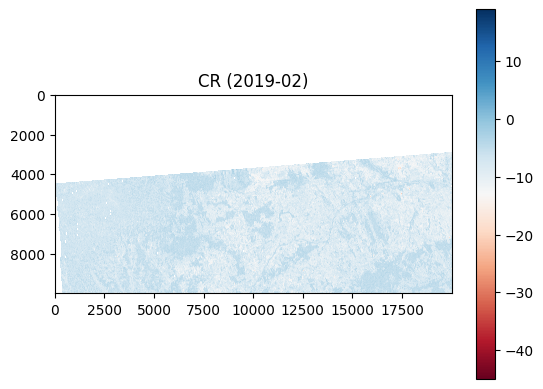

CR Min: -53
CR Max: 27


In [4]:
import numpy as np

# Function to calculate CR (Cross-Polarization Ratio) and mask NoData values (-9999)
def calculate_cr(vh_series, vv_series):
    # Mask NoData values (-9999) in both VH and VV series
    vh_series = np.ma.masked_where(vh_series == -9999, vh_series)
    vv_series = np.ma.masked_where(vv_series == -9999, vv_series)
    
    # Calculate CR as VH - VV, maintaining the mask
    cr_series = vh_series - vv_series
    return cr_series

# Calculate CR for all time steps (specific months and times)
cr_series = calculate_cr(vh_series, vv_series)

# Visualize the CR for the first loaded time step
plt.imshow(cr_series[0], cmap='RdBu')
plt.title(f"CR ({dates[0]})")
plt.colorbar()
plt.show()

# Check the range of CR values
print("CR Min:", cr_series.min())
print("CR Max:", cr_series.max())


In [5]:
# Check the range of CR values across all time steps
print("CR Min:", cr_series.min())
print("CR Max:", cr_series.max())


CR Min: -53
CR Max: 27


# 5

In [6]:
# Function to extract time series of values for each sampling point across all selected time steps
def extract_time_series_from_points(series, points_gdf, meta):
    points_gdf = points_gdf.to_crs(meta['crs'])  # Reproject sampling points to match the raster CRS
    time_series_data = []
    
    # Get the dimensions of the raster
    height, width = series.shape[1], series.shape[2]

    # For each point, extract the values for all time steps
    for _, point in points_gdf.iterrows():
        if point.geometry is None:
            time_series_data.append([np.nan] * series.shape[0])
            continue

        # Get row, col from geometry coordinates
        row, col = rasterio.transform.rowcol(meta['transform'], point.geometry.x, point.geometry.y)
        
        # Ensure indices are within bounds
        if 0 <= row < height and 0 <= col < width:
            values = series[:, row, col]  # Extract values across all time steps
            time_series_data.append(values)
        else:
            time_series_data.append([np.nan] * series.shape[0])
    
    return pd.DataFrame(time_series_data, columns=dates)

# Extract time series data for CR, VH, and VV for each sampling point
cr_time_series = extract_time_series_from_points(cr_series, sampling_points, vh_meta)
vh_time_series = extract_time_series_from_points(vh_series, sampling_points, vh_meta)
vv_time_series = extract_time_series_from_points(vv_series, sampling_points, vh_meta)

# Print the first few rows of the CR time series
print(cr_time_series.head())


  2019-02 2019-02 2019-05 2019-05 2019-08 2019-08 2019-11 2019-11 2020-02  \
0      --      -6      --      -3      --      -6      --      -3      --   
1      --     -13      --     -10      --     -10      --      -5      --   
2     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
3      -7      --     -12      --      -5      --      -7      --      -7   
4      --      -5      --      -5      --      -5      --      -6      --   

  2020-02  ... 2021-11 2021-11 2022-02 2022-02 2022-05 2022-05 2022-08  \
0      -4  ...      --      -1      --      -3      --     -10      --   
1      -7  ...      --      -3      --      -3      --      -5      --   
2     NaN  ...     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
3      --  ...      -5      --     -10      --     -10      --      -7   
4     -11  ...      --      -9      --      -6      --      -8      --   

  2022-08 2022-11 2022-11  
0      -9      --      -4  
1      -7      --      -6  
2     Na

# 6

In [7]:
# Replace -9999 with NaN in the time series data
cr_time_series.replace(-9999, np.nan, inplace=True)
vh_time_series.replace(-9999, np.nan, inplace=True)
vv_time_series.replace(-9999, np.nan, inplace=True)

# Calculate percentage of missing values in each time step
missing_cr = cr_time_series.isna().mean() * 100
missing_vh = vh_time_series.isna().mean() * 100
missing_vv = vv_time_series.isna().mean() * 100

print("CR Missing Values (%):", missing_cr)
print("VH Missing Values (%):", missing_vh)
print("VV Missing Values (%):", missing_vv)


CR Missing Values (%): 2019-02    15.454545
2019-02    15.454545
2019-05    15.454545
2019-05    15.454545
2019-08    15.454545
2019-08    15.454545
2019-11    15.454545
2019-11    15.454545
2020-02    15.454545
2020-02    15.454545
2020-05    15.454545
2020-05    15.454545
2020-08    15.454545
2020-08    15.454545
2020-11    15.454545
2020-11    15.454545
2021-02    15.454545
2021-02    15.454545
2021-05    15.454545
2021-05    15.454545
2021-08    15.454545
2021-08    15.454545
2021-11    15.454545
2021-11    15.454545
2022-02    15.454545
2022-02    15.454545
2022-05    15.454545
2022-05    15.454545
2022-08    15.454545
2022-08    15.454545
2022-11    15.454545
2022-11    15.454545
dtype: float64
VH Missing Values (%): 2019-02    72.727273
2019-02    42.727273
2019-05    72.727273
2019-05    42.727273
2019-08    72.727273
2019-08    43.636364
2019-11    72.727273
2019-11    42.727273
2020-02    72.727273
2020-02    42.727273
2020-05    72.727273
2020-05    42.727273
2020-08    72.7

# 7

In [8]:
from sklearn.impute import SimpleImputer

# Impute missing values with the median for each time step
imputer = SimpleImputer(strategy="median")
cr_time_series_imputed = pd.DataFrame(imputer.fit_transform(cr_time_series), columns=cr_time_series.columns)
vh_time_series_imputed = pd.DataFrame(imputer.fit_transform(vh_time_series), columns=vh_time_series.columns)
vv_time_series_imputed = pd.DataFrame(imputer.fit_transform(vv_time_series), columns=vv_time_series.columns)

# Verify that there are no NaNs left
print("Any NaNs remaining in CR:", cr_time_series_imputed.isna().any().any())
print("Any NaNs remaining in VH:", vh_time_series_imputed.isna().any().any())
print("Any NaNs remaining in VV:", vv_time_series_imputed.isna().any().any())


Any NaNs remaining in CR: False
Any NaNs remaining in VH: False
Any NaNs remaining in VV: False


c:\Users\z004m0zm\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\generic.py:2153: UserWarning: Warning: converting a masked element to nan.
  arr = np.asarray(values, dtype=dtype)
c:\Users\z004m0zm\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\generic.py:2153: UserWarning: Warning: converting a masked element to nan.
  arr = np.asarray(values, dtype=dtype)


# 8

In [9]:
from sklearn.cluster import KMeans

# Define the number of clusters (adjust as needed)
n_clusters = 4

# Perform clustering on CR, VH, and VV time series
cr_clusters = KMeans(n_clusters=n_clusters, random_state=0).fit_predict(cr_time_series_imputed)
vh_clusters = KMeans(n_clusters=n_clusters, random_state=0).fit_predict(vh_time_series_imputed)
vv_clusters = KMeans(n_clusters=n_clusters, random_state=0).fit_predict(vv_time_series_imputed)

# Add cluster labels to the sampling points DataFrame
sampling_points['cr_cluster'] = cr_clusters
sampling_points['vh_cluster'] = vh_clusters
sampling_points['vv_cluster'] = vv_clusters

# Display the first few rows with cluster assignments
print(sampling_points[['cr_cluster', 'vh_cluster', 'vv_cluster']].head())


Exception in thread Thread-7 (_readerthread):
Traceback (most recent call last):
  File "c:\Users\z004m0zm\AppData\Local\Programs\Python\Python312\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\z004m0zm\AppData\Roaming\Python\Python312\site-packages\ipykernel\ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "c:\Users\z004m0zm\AppData\Local\Programs\Python\Python312\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "c:\Users\z004m0zm\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 1599, in _readerthread
    buffer.append(fh.read())
                  ^^^^^^^^^
  File "c:\Users\z004m0zm\AppData\Local\Programs\Python\Python312\Lib\encodings\cp1252.py", line 23, in decode
    return codecs.charmap_decode(input,self.errors,decoding_table)[0]
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
UnicodeDecodeError: 'charmap' codec can't decode byte 0x81 in posi

   cr_cluster  vh_cluster  vv_cluster
0           2           0           2
1           0           0           0
2           0           0           0
3           0           0           0
4           0           0           2


# 9

In [11]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

# Select the August data for each year
august_indices = [dates.index(f"{year}-08") for year in range(2019, 2023)]
august_cr_series = cr_series[august_indices]  # Shape (4, height, width)
august_vh_series = vh_series[august_indices]
august_vv_series = vv_series[august_indices]

# Apply DBSCAN spatial clustering to each year's August data
def spatial_clustering(data_series, eps=0.5, min_samples=10):
    clustering_results = []
    for i in range(data_series.shape[0]):  # Iterate over each year (4 years)
        data = data_series[i].flatten().reshape(-1, 1)
        data = StandardScaler().fit_transform(data)  # Standardize data
        db = DBSCAN(eps=eps, min_samples=min_samples).fit(data)
        labels = db.labels_.reshape(data_series[i].shape)  # Reshape to original grid shape
        clustering_results.append(labels)
    
    return clustering_results

# Perform spatial clustering on CR, VH, and VV for August data
spatial_cr_clusters = spatial_clustering(august_cr_series)
spatial_vh_clusters = spatial_clustering(august_vh_series)
spatial_vv_clusters = spatial_clustering(august_vv_series)

# Plot spatial clustering results for CR for each August from 2019-2022
for i, year in enumerate(range(2019, 2023)):
    plt.imshow(spatial_cr_clusters[i], cmap='tab20')
    plt.title(f"CR Spatial Clustering - August {year}")
    plt.colorbar()
    plt.show()


MemoryError: 

In [ ]:
# Select the time step corresponding to August (adjust index as needed)
august_index = 2  # Assuming August is the 8th month in 0-indexing

# Perform KMeans clustering on the flattened August CR data
from sklearn.cluster import KMeans

# Downsample the data or use the full flattened data (if memory allows)
cr_august_flat = cr_series[august_index].flatten().reshape(-1, 1)
kmeans = KMeans(n_clusters=3, random_state=0).fit_predict(cr_august_flat)
cr_spatial_clusters = kmeans.reshape(cr_series[august_index].shape)

# Visualize the clustering results
plt.imshow(cr_spatial_clusters, cmap='tab20')
plt.title("CR Spatial Clustering (August, KMeans)")
plt.colorbar()
plt.show()



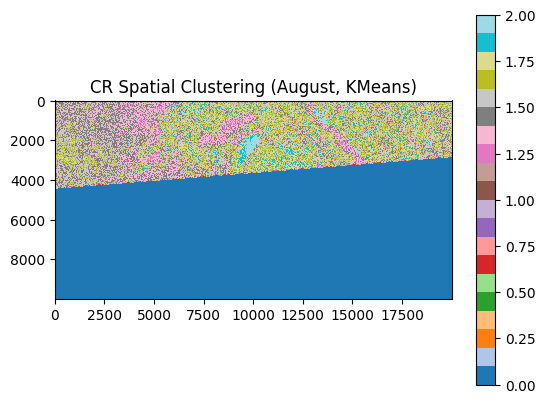

In [28]:
# Select the time step corresponding to August (adjust index as needed)
august_index = 7  # Assuming August is the 8th month in 0-indexing

# Perform KMeans clustering on the flattened August CR data
from sklearn.cluster import KMeans

# Downsample the data or use the full flattened data (if memory allows)
cr_august_flat = cr_series[august_index].flatten().reshape(-1, 1)
kmeans = KMeans(n_clusters=3, random_state=0).fit_predict(cr_august_flat)
cr_spatial_clusters = kmeans.reshape(cr_series[august_index].shape)

# Visualize the clustering results
plt.imshow(cr_spatial_clusters, cmap='tab20')
plt.title("CR Spatial Clustering (August, KMeans)")
plt.colorbar()
plt.show()



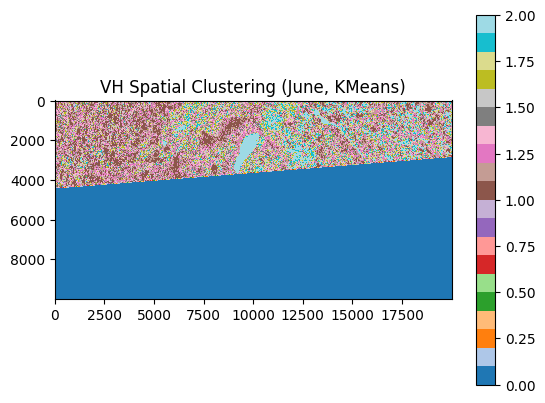

In [30]:
# Example: Analyze June VH data instead of August CR data
june_index = 5  # Set this to the index for the desired month (0-based indexing)

# Select the data for VH instead of CR
vh_june = vh_series[june_index].flatten().reshape(-1, 1)

# Perform clustering (e.g., KMeans or DBSCAN) on the selected time step and polarization
vh_spatial_clusters = KMeans(n_clusters=3, random_state=0).fit_predict(vh_june)
vh_spatial_clusters = vh_spatial_clusters.reshape(vh_series[june_index].shape)

# Visualize the clustering results for VH in June
plt.imshow(vh_spatial_clusters, cmap='tab20')
plt.title("VH Spatial Clustering (June, KMeans)")
plt.colorbar()
plt.show()
